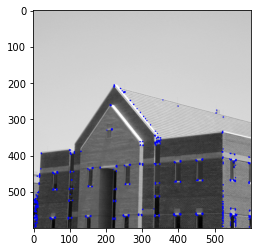

In [4]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
filename = 'building.tif'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)
#result is dilated for marking the corners, not important
dst = cv.dilate(dst,None)
# Threshold for an optimal value, it may vary depending on the image.
img[dst>0.01*dst.max()]=[0,0,255]

plt.imshow(img)
plt.show()

Image successfully read...
Finding Corners...


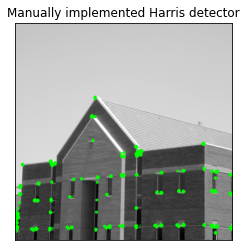

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt


def my_harris(img_dir,window_size,k,threshold):

    img = cv2.imread(img_dir)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    img_gaussian = cv2.GaussianBlur(gray,(3,3),0)

    # Check if the image is exists
    if img is None:
        print('Invalid image:' + img_dir)
        return None
    else:
        print('Image successfully read...')
        
    height = img.shape[0]   #.shape[0] outputs height 
    width = img.shape[1]    #.shape[1] outputs width .shape[2] outputs color channels of image
    matrix_R = np.zeros((height,width))
    
    #   Step 1 - Calculate the x e y image derivatives (dx e dy)
    dx = cv2.Sobel(img_gaussian, cv2.CV_64F, 1, 0, ksize=3)
    dy = cv2.Sobel(img_gaussian, cv2.CV_64F, 0, 1, ksize=3)
    # dy, dx = np.gradient(gray)

    #   Step 2 - Calculate product and second derivatives (dx2, dy2 e dxy)
    dx2=np.square(dx)
    dy2=np.square(dy)
    dxy=dx*dy

    offset = int( window_size / 2 )
    #   Step 3 - Calcular a soma dos produtos das derivadas para cada pixel (Sx2, Sy2 e Sxy)
    print ("Finding Corners...")
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            Sx2 = np.sum(dx2[y-offset:y+1+offset, x-offset:x+1+offset])
            Sy2 = np.sum(dy2[y-offset:y+1+offset, x-offset:x+1+offset])
            Sxy = np.sum(dxy[y-offset:y+1+offset, x-offset:x+1+offset])

            #   Step 4 - Define the matrix H(x,y)=[[Sx2,Sxy],[Sxy,Sy2]]
            H = np.array([[Sx2,Sxy],[Sxy,Sy2]])

            #   Step 5 - Calculate the response function ( R=det(H)-k(Trace(H))^2 )
            det=np.linalg.det(H)
            tr=np.matrix.trace(H)
            R=det-k*(tr**2)
            matrix_R[y-offset, x-offset]=R
    
    #   Step 6 - Apply a threshold
    cv2.normalize(matrix_R, matrix_R, 0, 1, cv2.NORM_MINMAX)
    for y in range(offset, height-offset):
        for x in range(offset, width-offset):
            value=matrix_R[y, x]
            if value>threshold:
                # cornerList.append([x, y, value])
                cv2.circle(img,(x,y),3,(0,255,0))
                
    # cv2.imwrite("%s_threshold_%s.png"%(img_dir[5:-4],threshold), img)
    plt.figure("Manually implemented Harris detector")
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title("Manually implemented Harris detector")
    plt.xticks([]), plt.yticks([])
    #plt.savefig('My_harris_detector-thresh_%s.png'%(threshold), bbox_inches='tight')
    plt.show()

my_harris("building.tif", 5, 0.04, 0.30) # Change this path to one that will lead to your image

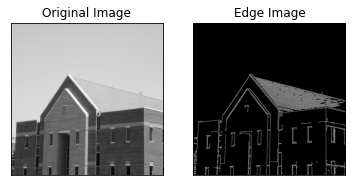

In [6]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('building.tif',0)
edges = cv.Canny(img,100,200)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [8]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

# read images
img1 = cv2.imread('img1.ppm')  
img2 = cv2.imread('img2.ppm') 

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#sift
sift = cv2.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

#feature matching
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:50], img2, flags=2)
plt.imshow(img3),plt.show()

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

In [ ]:
from __future__ import print_function
import cv2 as cv
import numpy as np
import argparse
from math import sqrt

## [load]
parser = argparse.ArgumentParser(description='Code for AKAZE local features matching tutorial.')
parser.add_argument('--input1', help='Path to input image 1.', default='graf1.png')
parser.add_argument('--input2', help='Path to input image 2.', default='graf3.png')
parser.add_argument('--homography', help='Path to the homography matrix.', default='H1to3p.xml')
args = parser.parse_args()

img1 = cv.imread(cv.samples.findFile(args.input1), cv.IMREAD_GRAYSCALE)
img2 = cv.imread(cv.samples.findFile(args.input2), cv.IMREAD_GRAYSCALE)
if img1 is None or img2 is None:
    print('Could not open or find the images!')
    exit(0)

fs = cv.FileStorage(cv.samples.findFile(args.homography), cv.FILE_STORAGE_READ)
homography = fs.getFirstTopLevelNode().mat()
## [load]

## [AKAZE]
akaze = cv.AKAZE_create()
kpts1, desc1 = akaze.detectAndCompute(img1, None)
kpts2, desc2 = akaze.detectAndCompute(img2, None)
## [AKAZE]

## [2-nn matching]
matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_BRUTEFORCE_HAMMING)
nn_matches = matcher.knnMatch(desc1, desc2, 2)
## [2-nn matching]

## [ratio test filtering]
matched1 = []
matched2 = []
nn_match_ratio = 0.8 # Nearest neighbor matching ratio
for m, n in nn_matches:
    if m.distance < nn_match_ratio * n.distance:
        matched1.append(kpts1[m.queryIdx])
        matched2.append(kpts2[m.trainIdx])
## [ratio test filtering]

## [homography check]
inliers1 = []
inliers2 = []
good_matches = []
inlier_threshold = 2.5 # Distance threshold to identify inliers with homography check
for i, m in enumerate(matched1):
    col = np.ones((3,1), dtype=np.float64)
    col[0:2,0] = m.pt

    col = np.dot(homography, col)
    col /= col[2,0]
    dist = sqrt(pow(col[0,0] - matched2[i].pt[0], 2) +\
                pow(col[1,0] - matched2[i].pt[1], 2))

    if dist < inlier_threshold:
        good_matches.append(cv.DMatch(len(inliers1), len(inliers2), 0))
        inliers1.append(matched1[i])
        inliers2.append(matched2[i])
## [homography check]

## [draw final matches]
res = np.empty((max(img1.shape[0], img2.shape[0]), img1.shape[1]+img2.shape[1], 3), dtype=np.uint8)
cv.drawMatches(img1, inliers1, img2, inliers2, good_matches, res)
#cv.imwrite("akaze_result.png", res)

inlier_ratio = len(inliers1) / float(len(matched1))
#print('A-KAZE Matching Results')
#print('*******************************')
#print('# Keypoints 1:                        \t', len(kpts1))
#print('# Keypoints 2:                        \t', len(kpts2))
#print('# Matches:                            \t', len(matched1))
#print('# Inliers:                            \t', len(inliers1))
#print('# Inliers Ratio:                      \t', inlier_ratio)

cv.imshow('result', res)
cv.waitKey()
## [draw final matches]